<a href="https://colab.research.google.com/github/JohnKeigo/Google-Colaboratory/blob/master/stable_textual_inversion.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **textual inversion/finetuning script**
# if you find good .yaml settings for the gpu's send them to me and i'll add them to the repo



kudos to the original creator of the script https://github.com/rinongal/textual_inversion

i modified it a little to work on multiple os and other things, you can find it here https://github.com/nicolai256/Stable-textual-inversion_win

please read this tutorial to gain some knowledge on how it works https://www.reddit.com/r/StableDiffusion/comments/wvzr7s/tutorial_fine_tuning_stable_diffusion_using_only/

# PLEASE BACKUP YOUR LOGS AND YAML FILES OR THEY MIGHT GET DELETED WHEN YOU RESTART A RUNTIME

# **check GPU**

In [1]:
# restart runtime until it gets better gpu
from IPython.display import HTML
from subprocess import getoutput
s = getoutput('nvidia-smi')
print(s)
# or simply
!nvidia-smi -L

Wed Aug 31 07:27:51 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla T4            Off  | 00000000:00:04.0 Off |                    0 |
| N/A   57C    P8    10W /  70W |      0MiB / 15109MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# **connect google drive**

In [2]:
from google.colab import drive
drive.mount('/content/drive')
!cd /content/drive/MyDrive/
!mkdir /content/drive/MyDrive/sd_text_inversion
!mkdir -p /content/drive/MyDrive/sd_text_inversion/Imagesfortraining

Mounted at /content/drive
mkdir: cannot create directory ‘/content/drive/MyDrive/sd_text_inversion’: File exists


# **put the stable diffusion model and training images in your google drive**







***put the model in your google drive in a folder named "sd_text_inversion"***

***put the training images inside a folder named "imagesfortraining" in there, make sure the files inside are only images***




# Squarizing the images with inpainting 

In [3]:
#@markdown Takes ~4mins
from IPython.display import clear_output

#use_gdrive=True #@param {type:"boolean"}
#if use_gdrive:
#  from google.colab import drive
#  drive.mount('/content/drive',force_remount="True")
!git clone https://github.com/corranmac/lamaSquarize.git
!pip install webdataset
print('Installing dependencies')
!pip install pyyaml tqdm easydict scikit-image scikit-learn tensorflow matplotlib joblib albumentations pandas hydra-core pytorch-lightning tabulate kornia tabulate packaging scikit-learn wldhx.yadisk-direct --quiet
#clear_output()
print('Changing the dir to:')
%cd /content/lamaSquarize
print('Downloading the model')
!curl -L $(yadisk-direct https://disk.yandex.ru/d/ouP6l8VJ0HpMZg) -o big-lama.zip

!unzip big-lama.zip
clear_output()
print('fixing opencv')
!pip uninstall opencv-python-headless -y --quiet
!pip install opencv-python-headless==4.1.2.30 --quiet

!python -m pip install 'git+https://github.com/facebookresearch/detectron2.git' --quiet
clear_output()
print("Done.")

Done.


In [4]:
#@title
import base64, os
from google.colab.output import eval_js
from base64 import b64decode
import matplotlib.pyplot as plt
from IPython.display import clear_output
import torch
import numpy as np
import cv2
import tqdm
from tqdm import tqdm
import natsort
from natsort import natsorted
import glob,shutil
from google.colab.patches import cv2_imshow
!mkdir /content/results3


In [9]:
from PIL import Image
import os, sys
import numpy
import PIL


path_to_input_images="/content/drive/MyDrive/sd_text_inversion/Imagesfortraining/"#@param ["/content/drive/MyDrive/sd_text_inversion/Imagesfortraining/"]
path=path_to_input_images
dirs = os.listdir( path )
outpathdark = "/content/drive/MyDrive/sd_text_inversion/Imagesfortrainingdark/"

from PIL import Image
def resize2():
    for item in dirs:
        if os.path.isfile(path+item):
          img = Image.open(path+item)
          # get width and height
          w = img.width
          h = img.height
          print("The height of the image is: ", img.height)
          print("The width of the image is: ", img.width)
          if img.width > img.height:
            new_width  = 512
            img = Image.open(path+item)
            new_height = int(new_width * h / w)
            img = img.resize((new_width,new_height), Image.ANTIALIAS)
            img.save(path+item)
          if img.height > img.width:
            new_height = 512
            img = Image.open(path+item)
            new_width  = int(new_height * w / h)
            img = img.resize((new_width,new_height), Image.ANTIALIAS)
            img.save(path+item)
            #return size
          print("next")
resize2()
def resize():
    for item in dirs:
        if os.path.isfile(path+item):
            image = Image.open(path+item).convert("RGB")
            f, e = os.path.splitext(path+item)
            #imResize = image.resize((200,200), Image.ANTIALIAS)
            #imResize.save(f + ' resized.jpg', 'JPEG', quality=90)
            w, h = image.size
            
            w2, h2 = map(lambda x: x - x % 2, (w, h))  # resize to integer multiple of 32
            image = image.resize((w2, h2), resample=PIL.Image.BICUBIC)
            image = image.save(path+item)
            #image = np.array(image).astype(np.float32) / 255.0
            #image = image[None].transpose(0, 3, 1, 2)
            #image = torch.from_numpy(image)
            #return 2.*image - 1.
            #print(f"loaded input image of size ({w2}, {h2}) from {image}")

resize()
clear_output()
print("images resized")
!cp -r /content/drive/MyDrive/sd_text_inversion/Imagesfortraining/* "/content/drive/MyDrive/sd_text_inversion/Imagesfortrainingdark/"
path_to_dark_input_images="/content/drive/MyDrive/sd_text_inversion/Imagesfortrainingdark/"
path2=path_to_dark_input_images
dirs = os.listdir( path2 )
outpathdark = "/content/drive/MyDrive/sd_text_inversion/Imagesfortrainingdark/"

from PIL import Image
from PIL import Image, ImageEnhance
def darken():
    for item in dirs:
        if os.path.isfile(path2+item):
          im = Image.open(path2+item)
          enhancer = ImageEnhance.Brightness(im)
          factor = 0 #darkens the image
          im_output = enhancer.enhance(factor)
          im_output.save(path2+item)
darken()
print("images for mask made")

images resized
images for mask made


In [10]:
#@title pad squarize images
import base64, os
import os
import shutil
extract_from="folder"
path_to_input_images="/content/drive/MyDrive/sd_text_inversion/Imagesfortraining/"
path=path_to_input_images
if not os.path.exists(path): raise Exception("The zip or folder doesn't exist, please check it.")
if extract_from=="zip":
  shutil.unpack_archive("/content/inputs","zip",path)
  path="/content/inputs/"
else:
  if not path.endswith("/"): path+="/"

import math
from math import ceil
import glob,shutil
import natsort
from natsort import natsorted
import tqdm
from tqdm import tqdm
import cv2
import numpy as np
from IPython.display import clear_output

from PIL import Image

c=0
files=glob.glob(path+"*")
files=natsorted(files)
output_folder="/content/drive/MyDrive/sd_text_inversion/Imagesfortraining_outpaint/" 
if not output_folder.endswith("/"): output_folder+="/"
if not os.path.exists(output_folder):
  os.mkdir(output_folder) 
print("Preprocessing images")
if os.path.exists("/content/temp/"):
  shutil.rmtree("/content/temp/")
!mkdir /content/temp
from google.colab.patches import cv2_imshow
if not os.path.exists(output_folder):
  !mkdir (output_folder)

from PIL import Image
import os, sys
import PIL
dirs = os.listdir( path )

for image in tqdm(files):
  
  i=cv2.imread(image)
  size=i.shape
  h,w=size[0],size[1]
  if w==h:
    shutil.move(os.path.join(image),output_folder)
  elif w==h-1:
    shutil.move(os.path.join(image),output_folder)
  elif w==h+1:
    shutil.move(os.path.join(image),output_folder)
  elif w-1==h:
    shutil.move(os.path.join(image),output_folder)
  elif w+1==h:
    shutil.move(os.path.join(image),output_folder)
  if w>h:
    newim=np.zeros((w,w,3),dtype=np.uint8)
    newim[:,:]=255
    pad=int((w-h)/2)
    padpad=int(w*0.04)
    newim[pad:w-pad,0:w]=0
    newim[:,:]=255
    #cv2.imwrite("/content/temp/"+str(c)+"_mask.png",newim)
    if pad>((w-h)/2):
      newim[pad-1:w-pad,0:w]=i[:,:]
    elif pad<((h-w)/2):
      newim[pad+1:w-pad,0:w]=i[:,:]
    #else:
     # newim[pad+1:w-pad,0:w]=i[:,:]
    else:
      newim[pad:w-pad,0:w]=i[:,:]
    cv2.imwrite("/content/temp/"+str(c)+".png",newim)
  else:
    newim=np.zeros((h,h,3),dtype=np.uint8)
    newim[:,:]=255
    pad=int((h-w)/2)
    newim[0:h,pad:h-pad]=0
    #cv2.imwrite("/content/temp/"+str(c)+"_mask.png",newim)
    newim[:,:]=255
    if pad>((h-w)/2):
      newim[0:h,pad-1:h-pad]=i[:,:]
    elif pad<((h-w)/2):
      newim[0:h,pad+1:h-pad]=i[:,:]
    else:
      newim[0:h,pad:h-pad]=i[:,:]
    cv2.imwrite("/content/temp/"+str(c)+".png",newim)
  c=c+1
  Exception("hi")
print("masks half done! starting resizer...")


Preprocessing images


100%|██████████| 3/3 [00:00<00:00, 64.92it/s]

masks half done! starting resizer...


In [11]:
#@title pad mask files

extract_from="folder"
path_to_input_dark_images="/content/drive/MyDrive/sd_text_inversion/Imagesfortrainingdark/"
path=path_to_input_dark_images
if not os.path.exists(path): raise Exception("The zip or folder doesn't exist, please check it.")
if extract_from=="zip":
  shutil.unpack_archive("/content/inputs","zip",path)
  path="/content/inputs/"
else:
  if not path.endswith("/"): path+="/"


c=0
files=glob.glob(path+"*")
files=natsorted(files)
#output_folder="/content/drive/MyDrive/sd_text_inversion/Imagesfortraining_outpaint/" #@param {type:"string"}
if not output_folder.endswith("/"): output_folder+="/"
if not os.path.exists(output_folder):
  os.mkdir(output_folder) 
print("Preprocessing images")
#if os.path.exists("/content/temp/"):
#  shutil.rmtree("/content/temp/")
#!mkdir /content/temp

#if not os.path.exists(output_folder):
#  !mkdir (output_folder)


dirs = os.listdir( path )

for image in tqdm(files):
  
  i=cv2.imread(image)
  size=i.shape
  h,w=size[0],size[1]
  if w==h:
    shutil.move(os.path.join(image),output_folder)
  elif w==h-1:
    shutil.move(os.path.join(image),output_folder)
  elif w==h+1:
    shutil.move(os.path.join(image),output_folder)
  elif w-1==h:
    shutil.move(os.path.join(image),output_folder)
  elif w+1==h:
    shutil.move(os.path.join(image),output_folder)
  if w>h:
    newim=np.zeros((w,w,3),dtype=np.uint8)
    newim[:,:]=255
    pad=int((w-h)/2)
    padpad=int(w*0.04)
    newim[pad:w-pad,0:w]=0
    newim[:,:]=255
    #cv2.imwrite("/content/temp/"+str(c)+"_mask.png",newim)
    if pad>((w-h)/2):
      newim[pad-1:w-pad,0:w]=i[:,:]
    elif pad<((h-w)/2):
      newim[pad+1:w-pad,0:w]=i[:,:]
    #else:
     # newim[pad+1:w-pad,0:w]=i[:,:]
    else:
      newim[pad:w-pad,0:w]=i[:,:]
    cv2.imwrite("/content/temp/"+str(c)+"_mask.png",newim)
  else:
    newim=np.zeros((h,h,3),dtype=np.uint8)
    newim[:,:]=255
    pad=int((h-w)/2)
    newim[0:h,pad:h-pad]=0
    #cv2.imwrite("/content/temp/"+str(c)+"_mask.png",newim)
    newim[:,:]=255
    if pad>((h-w)/2):
      newim[0:h,pad-1:h-pad]=i[:,:]
    elif pad<((h-w)/2):
      newim[0:h,pad+1:h-pad]=i[:,:]
    else:
      newim[0:h,pad:h-pad]=i[:,:]
    cv2.imwrite("/content/temp/"+str(c)+"_mask.png",newim)
  c=c+1
  Exception("hi")
print("masks Done! starting resizer...")


Preprocessing images


100%|██████████| 3/3 [00:00<00:00, 120.08it/s]

masks Done! starting resizer...


In [12]:
#@title **Careful this will resize any other images existing in your output_folder**
output_folder2="/content/temp/"
outputs=glob.glob(output_folder2+"*")
resize=True #@param {type:"boolean"}
resize_px=512 #@param {type:"integer"}
if resize:
  for out in outputs:
    im=cv2.imread(out)
    im=cv2.resize(im,(resize_px,resize_px))
    cv2.imwrite(out,im)

from PIL import Image
import os, sys

path = output_folder
dirs = os.listdir( path )

def resize3():
    for item in dirs:
        if os.path.isfile(path+item):
            im = Image.open(path+item)
            f, e = os.path.splitext(path+item)
            imResize = im.resize((resize_px,resize_px), Image.ANTIALIAS)
            imResize.save(f + '.png', 'PNG')

resize3()

print("resizing Done! starting inpainting...")
%cd /content/
if os.path.exists("/content/lamaSquarize"):
  os.rename("/content/lamaSquarize","/content/lama/")
os.chdir("/content/lama/")
mpath="/content/lama/big-lama/"
print("Inpainting")
!PYTHONPATH=. TORCH_HOME=$(pwd) python3 bin/predict.py model.path=$mpath indir="/content/temp/" outdir=$output_folder > /dev/null
clear_output()
print("Done!")
print("Outputs saved to "+output_folder)

Done!
Outputs saved to /content/drive/MyDrive/sd_text_inversion/Imagesfortraining_outpaint/


# **textual inversion get repo**




backup training files and delete the old repo version to ensure u get the newest version of the repo

In [13]:
%cd /content/drive/MyDrive/sd_text_inversion
!mkdir modelsbackup
!mv /content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/logs/ /content/drive/MyDrive/sd_text_inversion/modelsbackup/
!mv /content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/models/ldm/inpainting_big/last.ckpt /content/drive/MyDrive/sd_text_inversion/modelsbackup/last.ckpt
!rm -rf /content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win
%cd /content/drive/MyDrive/sd_text_inversion
!git clone https://github.com/nicolai256/Stable-textual-inversion_win.git
%cd /content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win
#!mv /content/drive/MyDrive/sd_text_inversion/modelsbackup/last.ckpt /content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/models/ldm/inpainting_big/last.ckpt
import os.path
from pathlib import Path
clear_output()
print("Done.")
#path_to_file = '/content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/models/ldm/inpainting_big/last.ckpt'
#path = Path(path_to_file)

#if path.is_file():
#    print(f'The file {path_to_file} exists')
#else:
#    print(f'The file {path_to_file} does not exist, downloading...')
#    !wget -O models/ldm/inpainting_big/last.ckpt https://heibox.uni-heidelberg.de/f/4d9ac7ea40c64582b7c9/?dl=1
#    print('downloaded file')


Done.


# **install**

In [14]:
%cd /content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win
!pip install omegaconf einops pytorch-lightning==1.6.5 test-tube transformers kornia -e git+https://github.com/CompVis/taming-transformers.git@master#egg=taming-transformers -e git+https://github.com/openai/CLIP.git@main#egg=clip
!pip install setuptools==59.5.0
!pip install pillow==9.0.1
!pip install torchmetrics==0.6.0
!pip install -e .
clear_output()
print("Done. run the cell under this to enable all packages")

Done. run the cell under this to enable all packages


you HAVE to run this cell under this text, it will give an crash error (Your session crashed for an unknown reason.) but it's just to refresh the environment so don't be alarmed, everything is still there



In [ ]:
import os
os._exit(00)

# **training info (PLEASE READ)**



---



training process images will appear in /content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/logs 

and will be named samples_scaled_gs

________________________________________

# **!!! IMPORTANT !!!**

# **init words**

**if u use `--init_word "clock"` but u wanna train on faces its gonna try to make a face from that clock and will look worse so try to describe your image with one word as closely as possible**


**if you really can't fit it in one word change this file and remove `--init_word "clock"`**

**keep in mind that if you use multiple initializer_words u need multiple placeholder_strings (from what i can tell atleast)**

**Open the v1-finetune.yaml file you will use for training, and find the initializer_words parameter. You should see the default value of**

`initializer_words:["sculpture"]` 

**and change this to** 

`initializer_words:["describe","your","subject"]` 

***or***

`initializer_words:["car","style","artistic", etc...]`

inside

**/content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/configs/stable-diffusion/v1-finetune.yaml**

or

**/content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/configs/stable-diffusion/v1-finetune_colabP100.yaml**

or

**/content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/configs/stable-diffusion/v1-finetune_colabT4.yaml**

# **placeholder_strings**


`placeholder_strings: ["*"]` (in the .yaml file) 

default is " * ", the " * " is the word/token u'll use in ur prompt to use the trained data

you change can change * to something else to later merge the trained embeddings 

(not sure which ones work but u can try these = * , *. , & , ^ , @ , # )

you will need to change line 86 personalized.py 

and line 64 in personalized_style.py

/content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/ldm/data/personalized.py 

/content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/ldm/data/personalized_style.py

for the best training speeds change /content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/configs/stable-diffusion/v1-finetune.yaml to the settings of your gpu, send a pull request if you make one so I can add it to the repo

(change *batch_size: number* and change *num_workers: number*)

**choose one of these according to the power of the gpu ur using**

pwerful gpu .yaml settings

/content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/configs/stable-diffusion/v1-finetune.yaml

---------------------------------------------------------------------------------------------------------------

**use this one if you run out of CUDA memory or get a mysterious ^C error**


P100 .yaml settings

/content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/configs/stable-diffusion/v1-finetune_colabP100.yaml

------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------

**if you have a free colab gpu use this one (or if you still run out of CUDA memory or get a mysterious ^C error)**








T4 .yaml settings

/content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/configs/stable-diffusion/v1-finetune_colabT4.yaml



# **actual** ***training***








In [ ]:
%cd /content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win
!python "main.py" \
 --base "configs/stable-diffusion/v1-finetune_colabT4.yaml" \
 -t --no-test \
 --actual_resume "/content/drive/MyDrive/sd_text_inversion/sd-v1-4.ckpt" \
 -n "myProjectName" \
 --gpus 1 \
 --data_root "/content/drive/MyDrive/sd_text_inversion/Imagesfortraining_outpaint" \
 --init_word "clock"

ストリーミング出力は最後の 5000 行に切り捨てられました。
DDIM Sampler:  85% 170/200 [01:47<00:18,  1.59it/s]

DDIM Sampler:  86% 171/200 [01:47<00:18,  1.58it/s]

DDIM Sampler:  86% 172/200 [01:48<00:17,  1.58it/s]

DDIM Sampler:  86% 173/200 [01:49<00:17,  1.58it/s]

DDIM Sampler:  87% 174/200 [01:49<00:16,  1.58it/s]

DDIM Sampler:  88% 175/200 [01:50<00:15,  1.58it/s]

DDIM Sampler:  88% 176/200 [01:50<00:15,  1.58it/s]

DDIM Sampler:  88% 177/200 [01:51<00:14,  1.59it/s]

DDIM Sampler:  89% 178/200 [01:52<00:13,  1.58it/s]

DDIM Sampler:  90% 179/200 [01:52<00:13,  1.58it/s]

DDIM Sampler:  90% 180/200 [01:53<00:12,  1.59it/s]

DDIM Sampler:  90% 181/200 [01:54<00:11,  1.58it/s]

DDIM Sampler:  91% 182/200 [01:54<00:11,  1.59it/s]

DDIM Sampler:  92% 183/200 [01:55<00:10,  1.59it/s]

DDIM Sampler:  92% 184/200 [01:55<00:10,  1.59it/s]

DDIM Sampler:  92% 185/200 [01:56<00:09,  1.59it/s]

DDIM Sampler:  93% 186/200 [01:57<00:08,  1.59it/s]

DDIM Sampler:  94% 187/200 [01:57<00:08,  1.59it/s]

DDIM Sampler: 

-------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------------





# **resume training**

try resuming with a lower base_learning_rate: 5.0e-04 (change yaml file)

 %cd /content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win
 
 !python "main.py" \

  --base "/content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/configs/stable-diffusion/v1-finetune.yaml" **replace with the yaml training file you use**

  -t --no-test \

  --actual_resume "/content/drive/MyDrive/sd_text_inversion/sd-v1-4.ckpt" **path to your 1.4 SD model**

  --gpus 1 \
  --data_root "/content/drive/MyDrive/sd_text_inversion/imagesfortraining"  **path to your training images**

  --project "/content/drive/MyDrive/sd_text_inversion/logs/projectdirectory" **path to your project**

  --embedding_manager_ckpt "/content/drive/MyDrive/sd_text_inversion/logs/projectdirectory/checkpoints/embeddings.pt" **path to the embedding u wanna resume**


  --resume_from_checkpoint "/content/drive/MyDrive/sd_text_inversion/logs/projectdirectory/checkpoints/last.ckpt" **last.ckpt file u wanna resume**

  -n "myProjectName2" **new name of project**


In [ ]:
%cd /content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win
!python "main.py" \
 --base "configs/stable-diffusion/v1-finetune_colabT4.yaml" \
 -t --no-test \
 --actual_resume "/content/drive/MyDrive/sd_text_inversion/sd-v1-4.ckpt" \
 --gpus 1 \
 --data_root "/content/drive/MyDrive/sd_text_inversion/Imagesfortraining_outpaint" \
 --project "logs/training images2022-08-28T07-55-48_myProjectName" \
 --embedding_manager_ckpt "logs/training images2022-08-28T07-55-48_myProjectName/checkpoints/embeddings.pt" \
 --resume_from_checkpoint "logs/training images2022-08-28T07-55-48_myProjectName/checkpoints/last.ckpt" \
 -n "myProjectName2"

# **generate/test**

for just after training

see output images from generating in

/content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/outputs

after you're done training your embeddings.pt model will be in a folder inside 

/content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/logs

___________________________________________________________________

if you want to load a embeddings.pt model from a previous session it will be in 

/content/drive/MyDrive/sd_text_inversion/modelsbackup

txt2img demo

In [ ]:
%cd /content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win
!python scripts/stable_txt2img.py \
 --ddim_eta 0.0 --n_samples 1 --n_iter 1 --scale 10.0 --ddim_steps 50 \
 --embedding_path "/content/drive/MyDrive/sd_text_inversion/modelsbackup/logs/modeldir/checkpoints/embeddings_gs-4499.pt" \
 --ckpt "/content/drive/MyDrive/sd_text_inversion/sd-v1-4.ckpt" \
 --prompt "*" --seed 50

img2img demo

In [ ]:
%cd /content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win 
!python scripts/img2img_colab.py --ddim_eta 0.0 --n_samples 1 --n_iter 1 --scale 10.0 --ddim_steps 50 --embedding_path "logs/training images2022-08-25T16-10-28_myProjectName/checkpoints/embeddings.pt" --ckpt /content/drive/MyDrive/sd_text_inversion/sd-v1-4.ckpt --prompt "a photo of *" --init_img /content/drive/MyDrive/sd_text_inversion/pathtoinitimg.jpg --strength 0.75

# ignore this it doesn't work

In [ ]:
#@title generation options
%cd /content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win
#@markdown Don't use short and simple prompts, complex prompts will give better results
prompt = "a photo of *" #@param {type:"string"}

#@markdown The more steps you use, the better image you get, but I don't recommend using more than 150 steps
steps = 50 #@param {type:"integer"}

n_sampless = 1 #@param {type:"integer"}

n_iter = 1 #@param {type:"integer"}

scale = 10 #@param {type:"integer"}

#@markdown I'm not sure about sampler, just play around with both of them. I've heard that ddim is slower but better and plms is faster but worse.
sampler = "ddim"  # @param ["plms", "ddim"]

#@markdown path to your trained textual inversion checkpoint

Embeddingpath = "/content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win/logs/training images2022-08-25T16-10-28_myProjectName/checkpoints/embeddings.pt" #@param {type:"string"}

#@markdown path to your stable diffusion model

stable_diffusion_path = "/content/drive/MyDrive/sd_text_inversion/sd-v1-4.ckpt" #@param {type:"string"}

if sampler == "ddim":
    plms = True
else:
    plms = False

#!python scripts/stable_txt2img.py --ddim_eta 0.0 --n_samples 1 --n_iter 1 --scale scale --ddim_steps steps --embedding_path Embeddingpath --ckpt stable_diffusion_path --prompt prompt

/content/drive/MyDrive/sd_text_inversion/Stable-textual-inversion_win


In [ ]:
grid_count = text2image(prompt = prompt, ddim_steps = steps, plms = plms, embedding_path = Embeddingpath)

Loading model from models/ldm/text2img-large/model.ckpt


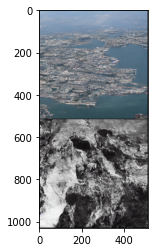

In [ ]:
from matplotlib.pyplot import imshow

img = Image.open(f"/content/output/grid-{grid_count-1:04}.png")

imshow(img)

In [ ]:
torch.cuda.empty_cache()